In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# from backtest import executer
import matplotlib.pyplot as plt
import plotly.express as px
import math
import ast
from scipy.stats import spearmanr, kstest


In [2]:
sns.set(rc={'figure.figsize':(15,8)})

In [96]:
portfolio = pd.read_excel('PORTFOLIO.xlsx')

df = pd.read_csv('resultado_VAR05_.csv')

df['date'] = pd.to_datetime(df.date)
df['open_date'] = pd.to_datetime(df.open_date)
df['days_open'] = df['days_open'].astype(float)
df['stock1'] = [pair.split("'")[1] for pair in df.pair]

In [97]:
df = df.merge(portfolio.drop_duplicates('ticker'), left_on='stock1', right_on='ticker',how='left')

df.drop(columns=['stock1', 'ticker'], inplace=True)
df['pair'] = df.pair.apply(ast.literal_eval)
df['sorted_pair'] = df.pair.apply(sorted).apply(tuple)

In [98]:
df.drop_duplicates(subset=['date', 'sorted_pair'], keep='first',inplace=True)

In [99]:
df.loc[df['residual_open'] < df['std_open_residual'], 'side'] = 'lower'
df.loc[df['residual_open'] > df['std_open_residual'], 'side'] = 'upper'

In [100]:
returns_list = []
i=1
closed = df.loc[df.status=='close']

for row in closed.itertuples():

    historico_par = df.loc[(df.pair==row.pair) & (df.date.between(row.open_date,row.date))].copy()
    historico_par.set_index('date', inplace=True)
    historico_par['id'] = i
    
    
#     display(historico_par)
#     Custo entrada: 1,22% + 0,1% = 1,31%
#     Custo saida: 1,22% + 0,25% + 0,1% = 1,57% + Aluguel
    
#     display(historico_par)
    aluguel = (1.0143)**((row.days_open+2)/252) -1
    try:
        if row.side == 'lower':
            
            historico_par['ratio_sem_custos'] = historico_par['price_fst_stock'] / historico_par['price_scnd_stock']
            
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.at[row.open_date, 'price_fst_stock']
            
            # Entrada
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.loc[row.open_date, 'price_fst_stock'] * (1+0.0071)
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock'] * (1-0.0071)
            
                    
            # Saída
            historico_par.at[row.date, 'price_fst_stock'] = historico_par.loc[row.date, 'price_fst_stock'] * (1-0.0071)
            historico_par.at[row.date, 'price_scnd_stock'] = historico_par.loc[row.date, 'price_scnd_stock'] * (1+(0.0071+aluguel))

            historico_par['ratio'] = historico_par['price_fst_stock'] / historico_par['price_scnd_stock']
            
        else:
            
            historico_par['ratio_sem_custos'] = historico_par['price_scnd_stock'] / historico_par['price_fst_stock']
            
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock']
            # Entrada
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock'] * (1+0.0071)
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.loc[row.open_date, 'price_fst_stock'] * (1-0.0071)

            # Saida
            historico_par.at[row.date, 'price_scnd_stock'] = historico_par.loc[row.date, 'price_scnd_stock'] * (1-0.0071)
            historico_par.at[row.date, 'price_fst_stock'] = historico_par.loc[row.date, 'price_fst_stock'] * (1+(0.0071+aluguel))

            historico_par['ratio'] = historico_par['price_scnd_stock'] / historico_par['price_fst_stock']
        
        
        historico_par['open_price_first_stock'] = historico_par.at[row.open_date, 'price_fst_stock']
        historico_par['open_price_scnd_stock'] = historico_par.at[row.open_date, 'price_scnd_stock']
        
        historico_par['return'] = (historico_par.ratio / historico_par.ratio.shift(1)) -1
        historico_par['retorno_acumulado'] = np.cumprod(1+historico_par['return']) -1
        
        historico_par['return_sem_custos'] = (historico_par.ratio_sem_custos / historico_par.ratio_sem_custos.shift(1)) -1
        historico_par['retorno_acumulado_sem_custos'] = (np.cumprod(1+historico_par['return_sem_custos']) -1)
        
        returns_list.append(historico_par)
        
    except Exception as e:
#         print(e)
        pass
    
    i+=1

In [101]:
def result_calculator(row, kind='CN'):
    
    if kind=='CN':
        multiplier = 1
    if kind == 'BN':
        multiplier = row.beta_open
    
    if row['residual_open'] < row['std_open_residual']:
        long_result =(row['price_fst_stock'] / row['open_price_first_stock'])
        short_result = (row['open_price_scnd_stock'] / row['price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = (long_result * short_result) - 1
        
        return result, 'lower'
    
    elif row['residual_open'] > row['std_open_residual']:
        long_result = (row['open_price_first_stock'] / row['price_fst_stock'])
        short_result = (row['price_scnd_stock'] / row['open_price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = (long_result * short_result) - 1

        return result, 'upper'

In [102]:
df_returns = pd.concat(returns_list)
df_returns.reset_index(inplace=True)

In [103]:
df_returns = df_returns.set_index('date').loc['2019-01-01':]

<ipython-input-103-8e37df69150d>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_returns = df_returns.set_index('date').loc['2019-01-01':]


In [104]:
df_returns.reset_index(inplace=True)

In [105]:
log_retorno = np.log(1+df_returns.set_index(['date', 'pair', 'open_date','status'])[['return', 'return_sem_custos']]).fillna(0)
retorno_acumulado =  np.exp(log_retorno.cumsum()) - 1
retorno_acumulado.reset_index(inplace=True)

In [106]:
df_returns.halflife.mean()

7.941331417624521

In [107]:
closed = df_returns.loc[df_returns.status=='close']

In [108]:
ibov = pd.read_csv('ibov.csv', usecols=[0,4], index_col=0)
ibov.index = pd.to_datetime(ibov.index)
ibov = ibov.loc[df_returns.date.min():df_returns.date.max()]

In [109]:
log_ret_ibov = np.log(ibov/ibov.shift())
ibov_return = ibov/ibov.shift() -1
ibov_retornos = ibov/ibov.shift() -1
cumsum_ibov = np.cumsum(log_ret_ibov)
ibov_pct = np.exp(cumsum_ibov) -1

In [110]:
# Retorno com custos
acumulado_com_custos = np.cumprod(1+df_returns.groupby('date').mean()['return']) -1

In [111]:
# Resultado sem custos por dia
acumulado_sem_custo = np.cumprod(1+df_returns.groupby('date').mean().return_sem_custos) -1

In [112]:
acumulado_sem_custo

date
2019-01-02         NaN
2019-01-03    0.000550
2019-01-04    0.008547
2019-01-07    0.006639
2019-01-08    0.006101
                ...   
2022-06-27    0.891176
2022-06-28    0.866628
2022-06-29    0.865692
2022-06-30    0.869881
2022-07-01    0.846945
Name: return_sem_custos, Length: 869, dtype: float64

In [113]:
np.cumprod(1+df_returns.return_sem_custos)

0             NaN
1        1.004461
2        0.991460
3        1.003117
4        0.974504
          ...    
8347    83.592844
8348    85.627998
8349    79.106127
8350          NaN
8351    81.704182
Name: return_sem_custos, Length: 8352, dtype: float64

In [114]:
# Operações Fechadas
fechadas = df_returns.loc[df_returns.status=='close']

fechadas['e_lucro_bruto'] = fechadas['retorno_acumulado_sem_custos'] > 0
fechadas['e_lucro_liquido'] = fechadas['retorno_acumulado'] > 0

retorno_diario = df_returns.groupby('date').mean()

<ipython-input-114-df0e1999672d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas['e_lucro_bruto'] = fechadas['retorno_acumulado_sem_custos'] > 0
<ipython-input-114-df0e1999672d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas['e_lucro_liquido'] = fechadas['retorno_acumulado'] > 0


# Graficos

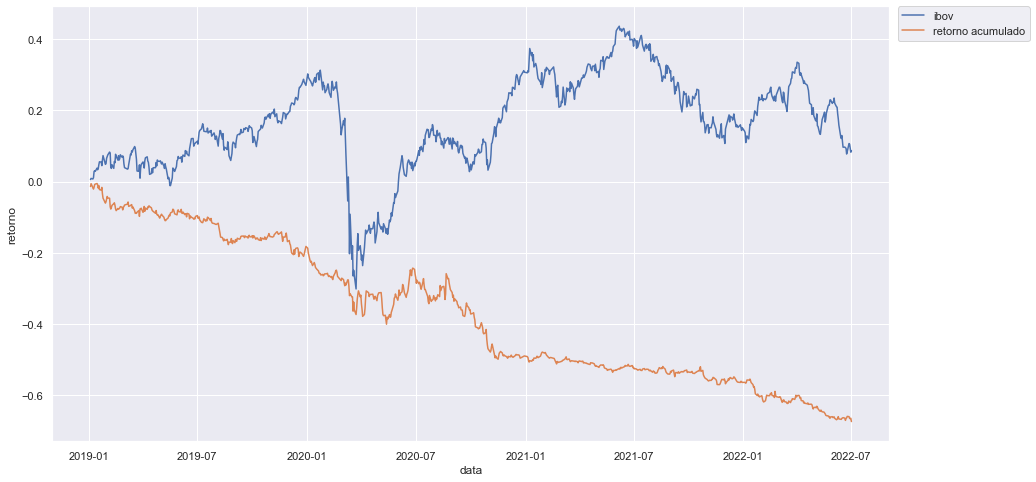

In [115]:
sns.lineplot(x=ibov_pct.index, y=ibov_pct.close, label='ibov')
sns.lineplot(x=acumulado_com_custos.index, y=acumulado_com_custos, label='retorno acumulado')
plt.ylabel('retorno')
plt.xlabel('data')

plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# sns.lineplot(x=cumsum_result_BN.index, y=cumsum_result_BN, label='cointegration beta neutral')


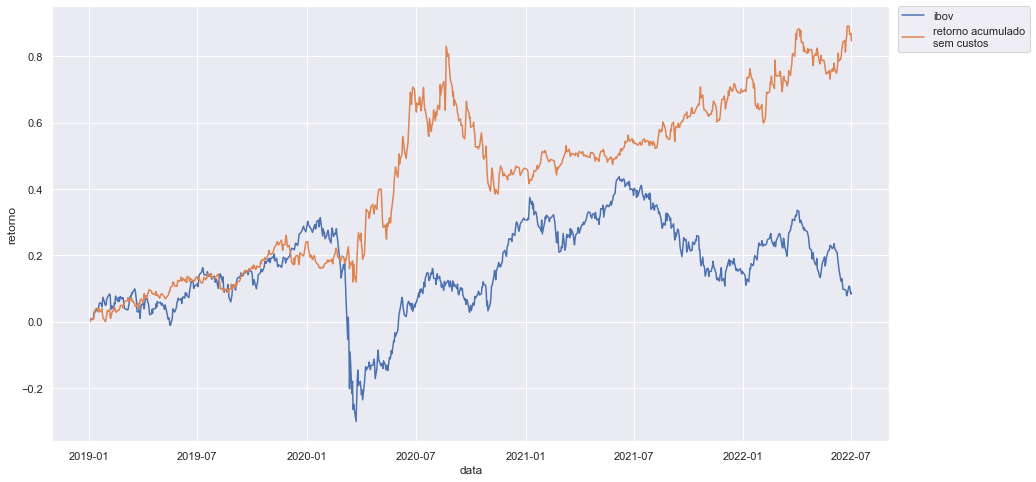

In [116]:
sns.lineplot(x=ibov_pct.index, y=ibov_pct.close, label='ibov')
sns.lineplot(x=acumulado_sem_custo.index, y=acumulado_sem_custo, label='retorno acumulado\nsem custos')
plt.ylabel('retorno')
plt.xlabel('data')

plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [117]:
retornos_diarios = pd.concat([ibov_return, retorno_diario[['return', 'return_sem_custos']]], axis=1)
retornos_diarios.fillna(0, inplace=True)
retornos_diarios.columns = ['ibov', 'retorno_com_custos', 'retorno_sem_custos']

In [118]:
log_retornos = np.log(1+retornos_diarios)
retornos_acumulados = np.exp(log_retornos.cumsum()) -1
retornos_acumulados

,ibov,retorno_com_custos,retorno_sem_custos
2019-01-02,0.000000,0.000000,0.000000
2019-01-03,0.006065,-0.013558,0.000550
2019-01-04,0.009109,-0.005673,0.008547
2019-01-07,0.007548,-0.016838,0.006639
2019-01-08,0.011207,-0.020816,0.006101
...,...,...,...
2022-06-27,0.107151,-0.660407,0.891176
2022-06-28,0.105250,-0.665498,0.866628
2022-06-29,0.094603,-0.665666,0.865692
2022-06-30,0.082736,-0.664915,0.869881


# Descritivas

In [119]:
retornos_diarios.describe()

,ibov,retorno_com_custos,retorno_sem_custos
count,869.000000,869.000000,869.000000
mean,0.000264,-0.001218,0.000778
std,0.018184,0.011998,0.012065
min,-0.147797,-0.059177,-0.053780
25%,-0.007812,-0.007206,-0.005540
50%,0.000781,-0.000752,0.000410
75%,0.009616,0.005255,0.006846
max,0.139082,0.083922,0.093424


In [120]:
coeficiente_liquido, p_valor = spearmanr(retornos_diarios[['ibov', 'retorno_com_custos']])
print('Correlação de Spearman Resutado líquido: {:0.3}'.format(coeficiente_liquido))

Correlação de Spearman Resutado líquido: 0.0658


In [121]:
coeficiente_bruto, p_valor = spearmanr(retornos_diarios[['ibov', 'retorno_sem_custos']])
print('Correlação de Spearman Resutado bruto: {:0.3}'.format(coeficiente_bruto))

Correlação de Spearman Resutado bruto: 0.0686


In [122]:
# TESTE NORMALIDADE
#perform Kolmogorov-Smirnov test
kstest(retornos_diarios.retorno_sem_custos, 'norm')

KstestResult(statistic=0.48310712960569746, pvalue=3.413149358982242e-187)

In [123]:
# TESTE NORMALIDADE
#perform Kolmogorov-Smirnov test
kstest(retornos_diarios.retorno_com_custos, 'norm')

KstestResult(statistic=0.4808056336333154, pvalue=2.642445370337738e-185)

# Eficacia

In [124]:
eficacia = fechadas.set_index('open_date').resample('6M').agg(
    num_operacoes = ('pair', 'count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    tempo_medio_operacao = ('days_open', 'mean')
)

eficacia

,num_operacoes,taxa_acerto,tempo_medio_operacao
open_date,,,
2019-01-31,17,0.588235,10.117647
2019-07-31,83,0.674699,24.807229
2020-01-31,51,0.647059,13.431373
2020-07-31,103,0.601942,9.067961
2021-01-31,55,0.527273,27.745455
2021-07-31,45,0.644444,25.644444
2022-01-31,46,0.565217,13.695652
2022-07-31,97,0.556701,9.319588


# Desempenho

In [125]:
vol_ibov = log_ret_ibov.close.std() * math.sqrt(252)
vol_ibov

0.2925497675155498

In [126]:
log_return = np.log(1+retorno_diario['return'])
vol_return = log_return.std() * math.sqrt(252)
vol_return

0.19046643974114943

In [127]:
log_return_sem_custo = np.log(1+retorno_diario['return_sem_custos'])
vol_return_sem_custo = log_return_sem_custo.std() * math.sqrt(252)
vol_return_sem_custo

0.19063589911070272

In [128]:
retorno_acumulado_bruto = retorno_acumulado['return_sem_custos'].iloc[-1]
taxa_acerto = fechadas['e_lucro_bruto'].mean()
retorno_acumulado_liquido = retorno_acumulado['return'].iloc[-1]

desempenho = pd.DataFrame([{
    'retorno_acumulado_bruto':retorno_acumulado_bruto,
    'taxa_acerto': taxa_acerto,
    'retorno_acumulado_liquido': retorno_acumulado_liquido,
    'desvio_padrao': vol_return,
    'sharpe': retorno_acumulado_liquido/vol_return,
    'correlacao_ibov': coeficiente_liquido
    }])

desempenho

,retorno_acumulado_bruto,taxa_acerto,retorno_acumulado_liquido,desvio_padrao,sharpe,correlacao_ibov
0,80.704182,0.60161,-0.999964,0.190466,-5.250077,0.065777


In [129]:
fechadas_halflife = fechadas.loc[(fechadas.days_open > fechadas.halflife) & (fechadas.beta_close!='VAR CLOSE')]
fechadas_stop_var = fechadas.loc[(fechadas.beta_close=='VAR CLOSE')]
fechadas_retorno = fechadas.loc[(abs(fechadas.last_residual) <= fechadas.close_limit) & (fechadas.beta_close!='VAR CLOSE') & (fechadas.days_open <= fechadas.halflife)]

In [130]:
todos_indices = fechadas_stop_var.index.tolist() + fechadas_halflife.index.tolist() + fechadas_retorno.index.tolist()

seen = set()
dupes = [x for x in todos_indices if x in seen or seen.add(x)]    

In [131]:
set(fechadas.index.tolist()) - set(todos_indices)

{7678, 8053, 8099}

In [132]:
fechadas.groupby('setor').agg('sum')

,price_fst_stock,price_scnd_stock,beta_open,last_residual,std_residual,std_open_residual,residual_open,open_price_first_stock,open_price_scnd_stock,close_limit,...,var_limit,id,ratio_sem_custos,ratio,return,retorno_acumulado,return_sem_custos,retorno_acumulado_sem_custos,e_lucro_bruto,e_lucro_liquido
setor,,,,,,,,,,,,,,,,,,,,,
Alimentos e Bebidas,129.488542,138.522371,8.492752,-16.358828,14.005609,11.869967,-9.362041,145.632609,142.731268,5.934984,...,-0.321289,1449,6.478981,6.382540,0.122741,-0.102883,0.230597,0.101477,5,4
Aéreas,210.514931,188.227954,4.527120,5.108977,8.196917,7.467467,-4.814386,202.775521,190.034908,3.733733,...,-0.203077,1233,4.787757,4.716656,-0.197088,-0.199487,-0.095711,-0.027567,3,2
Bens Industriais,237.987911,261.508150,15.517782,-11.260333,15.522407,14.157377,-5.585036,249.243091,266.124365,7.078688,...,-0.574102,3647,14.025389,13.815428,-0.036965,0.257782,0.262397,0.769629,11,10
Construção Civil,83.789468,85.539630,4.285753,-1.379260,6.249487,5.903019,-7.656836,95.157020,92.279955,2.951510,...,-0.134128,1902,5.650436,5.552957,-0.015644,-0.205693,0.070026,-0.053731,1,0
Educação,8.709432,64.317841,0.599018,-0.390983,1.651538,1.420656,-1.126202,10.302130,70.874768,0.710328,...,-0.128887,1091,14.561775,14.349107,0.033241,-0.257656,0.098674,-0.172932,1,1
Exploração de imóveis,161.992479,222.443100,8.699860,-3.928344,4.509078,4.278500,2.025311,162.891936,216.309938,2.139250,...,-0.224090,2026,7.921265,7.804031,-0.241846,-0.047606,-0.051415,0.277312,7,7
Financeiro,3408.354698,3864.067995,255.548358,-68.707705,203.260405,180.521290,-57.012486,3458.950333,3893.555820,90.260645,...,-6.820529,41118,256.667596,252.753228,-1.160786,-4.447933,1.875697,0.993870,104,71
Mineração e Siderurgia,730.782713,559.993573,46.272009,3.819339,28.931745,26.376177,15.602826,721.420190,546.019515,13.188088,...,-1.051299,9729,35.352462,34.818067,-0.348262,-1.009416,0.275448,-0.003029,20,12
Papel e Celulose,159.933179,294.270384,3.012716,-0.794471,5.467993,5.596192,0.238764,163.715730,298.236508,2.798096,...,-0.153175,2402,4.505727,4.439278,-0.078712,0.062927,0.011324,0.243131,5,4


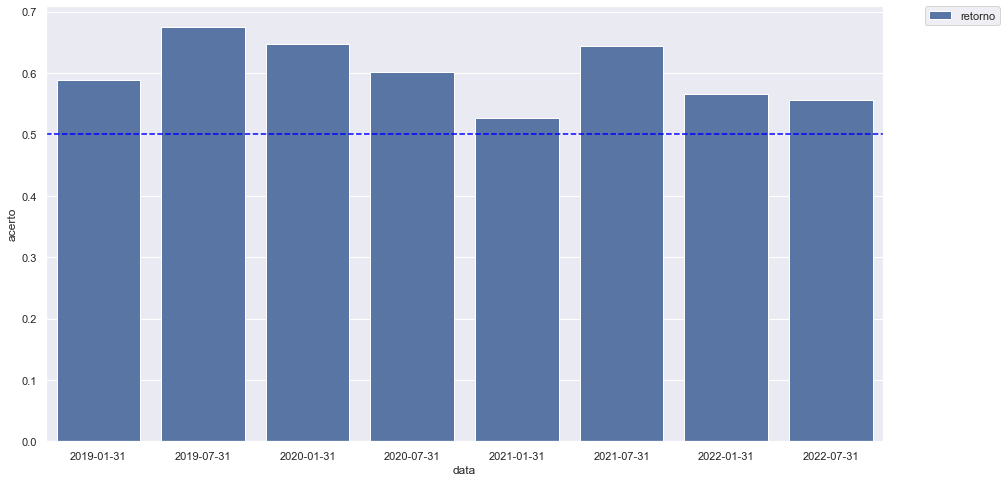

In [133]:
halfyear_accuracy = fechadas.set_index('open_date').resample('6M')[['e_lucro_bruto']].mean().reset_index()
halfyear_accuracy.columns = ['open_date', 'retorno']
halfyear_accuracy['open_date'] = halfyear_accuracy['open_date'].dt.date
halfyear_accuracy = halfyear_accuracy.melt(id_vars='open_date', value_name='acerto')

sns.barplot(x='open_date', y='acerto', hue='variable', data=halfyear_accuracy)
plt.axhline(y=0.5, color='blue', linestyle='--')
plt.xlabel('data')
# plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [134]:
halfyear_accuracy

,open_date,variable,acerto
0,2019-01-31,retorno,0.588235
1,2019-07-31,retorno,0.674699
2,2020-01-31,retorno,0.647059
3,2020-07-31,retorno,0.601942
4,2021-01-31,retorno,0.527273
5,2021-07-31,retorno,0.644444
6,2022-01-31,retorno,0.565217
7,2022-07-31,retorno,0.556701


In [135]:
fechadas

,date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,std_open_residual,...,side,id,ratio_sem_custos,ratio,return,retorno_acumulado,return_sem_custos,retorno_acumulado_sem_custos,e_lucro_bruto,e_lucro_liquido
44,2019-06-27,"(CCRO3, ECOR3)",close,13.277492,10.524740,1.192578,1.237477988311964,0.113545,0.655360,0.424324,...,upper,1,0.806084,0.792675,0.001948,0.038595,0.018896,0.071268,True,True
49,2019-02-01,"(BRML3, MULT3)",close,13.439225,24.385624,0.599995,VAR CLOSE,0.019772,0.321958,0.322953,...,upper,2,1.841079,1.814511,0.005838,0.014003,0.020566,0.043565,True,True
62,2019-05-16,"(BRML3, MULT3)",close,10.882184,21.034646,0.609782,0.6016952811957026,-0.124353,0.301041,0.299057,...,lower,3,0.525156,0.517346,-0.008576,0.002012,0.006391,0.031686,True,True
98,2019-07-29,"(BRML3, MULT3)",close,13.970103,26.894831,0.591845,0.5583000438611563,-0.133123,0.347485,0.305714,...,lower,4,0.527955,0.519434,0.009110,0.003483,0.025663,0.034530,True,True
106,2019-08-05,"(MULT3, BRML3)",close,26.260703,13.761594,1.612919,1.7071945376963982,0.162806,0.607337,0.491615,...,upper,5,0.532872,0.524038,-0.008388,0.004810,0.008329,0.036363,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8320,2022-03-14,"(SOMA3, ALPA4)",close,11.701984,22.002664,0.213015,0.1820249811011287,0.533469,1.322106,1.245217,...,upper,520,1.910345,1.880251,0.000985,-0.082692,0.017006,-0.054681,False,False
8342,2022-06-07,"(SOMA3, ASAI3)",close,10.564456,15.831829,0.811444,VAR CLOSE,-4.103269,1.635415,1.529091,...,lower,521,0.677707,0.667292,-0.069999,-0.087372,-0.055484,-0.059873,False,False
8344,2022-04-05,"(VIIA3, CVCB3)",close,4.001387,17.405609,0.773178,VAR CLOSE,-3.501767,1.520897,1.518323,...,lower,522,0.233218,0.229891,-0.092871,-0.092871,-0.066582,-0.066582,False,False
8349,2022-04-08,"(VIIA3, LREN3)",close,3.574440,26.767631,0.645305,VAR CLOSE,-1.436871,1.164183,1.150397,...,lower,523,0.135491,0.133536,-0.089497,-0.097280,-0.076165,-0.070963,False,False


In [136]:
display(fechadas.groupby(['setor', 'open_date']).e_lucro_bruto.mean().reset_index())

,setor,open_date,e_lucro_bruto
0,Alimentos e Bebidas,2020-01-23,1.0
1,Alimentos e Bebidas,2020-02-28,0.0
2,Alimentos e Bebidas,2020-04-16,0.0
3,Alimentos e Bebidas,2020-05-13,1.0
4,Alimentos e Bebidas,2020-08-24,1.0
...,...,...,...
422,Varejo,2022-05-09,0.5
423,Varejo,2022-05-18,0.0
424,Varejo,2022-06-02,1.0
425,Varejo,2022-06-03,1.0


Text(0, 0.5, 'acerto')

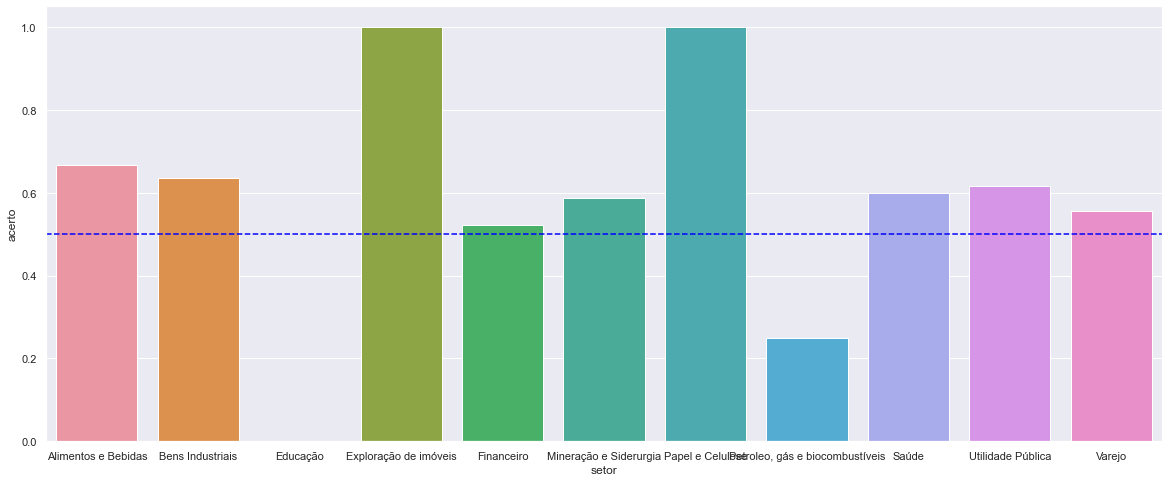

In [137]:
fechadas_agrupadas_semestre = fechadas.groupby(['setor', pd.Grouper(key='open_date', freq='1Y')]).e_lucro_bruto.mean().reset_index()

plt.figure(figsize=(20,8))

fechadas_agrupadas_semestre['open_date'] = pd.to_datetime(fechadas_agrupadas_semestre['open_date'])
fechadas_2020 = fechadas_agrupadas_semestre.set_index('open_date').loc['2020'].reset_index()
fechadas_2020['open_date'] = fechadas_2020.open_date.dt.date

sns.barplot(x='setor', y='e_lucro_bruto', data=fechadas_2020)
plt.axhline(y=0.5, color='blue', linestyle='--')

plt.ylabel('acerto')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



In [138]:
fechadas_var_semestre = fechadas_stop_var.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_halflife = ('e_lucro_bruto', 'mean'),
)
fechadas_var_semestre['loss_halflife'] = 1-fechadas_var_semestre['gain_halflife']

fechadas_var_semestre

,total_trades,gain_halflife,loss_halflife
open_date,,,
2019-01-31,13,0.461538,0.538462
2019-07-31,50,0.460000,0.540000
2020-01-31,29,0.413793,0.586207
2020-07-31,68,0.441176,0.558824
2021-01-31,32,0.343750,0.656250
2021-07-31,26,0.423077,0.576923
2022-01-31,34,0.441176,0.558824
2022-07-31,68,0.455882,0.544118


In [139]:
halflife_semestre = fechadas_halflife.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_halflife = ('e_lucro_bruto', 'mean'),
)

halflife_semestre['loss_halflife'] = 1-halflife_semestre['gain_halflife']

halflife_semestre

,total_trades,gain_halflife,loss_halflife
open_date,,,
2019-01-31,1,1.000000,0.000000
2019-07-31,24,1.000000,0.000000
2020-01-31,19,0.947368,0.052632
2020-07-31,22,0.863636,0.136364
2021-01-31,21,0.761905,0.238095
2021-07-31,15,0.933333,0.066667
2022-01-31,10,0.900000,0.100000
2022-07-31,17,0.823529,0.176471


# Resumo Pares

In [140]:
fechadas_grouped = fechadas.groupby('sorted_pair').agg(
    trades = ('sorted_pair','count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    prazo_medio_operacao = ('days_open', 'mean'),
    retorno_bruto_acum = ('retorno_acumulado_sem_custos', 'sum'),
    retorno_liquidi_acum = ('retorno_acumulado', 'sum')
)

fechadas_grouped.sort_values(by=['trades', 'taxa_acerto'], ascending=False).head(15)

,trades,taxa_acerto,prazo_medio_operacao,retorno_bruto_acum,retorno_liquidi_acum
sorted_pair,,,,,
"(PETR3, PETR4)",17,0.882353,13.882353,0.186008,-0.310134
"(ELET3, ELET6)",13,0.538462,16.307692,0.195510,-0.187058
"(EQTL3, TAEE11)",12,0.750000,13.333333,0.631220,0.266918
"(BRML3, MULT3)",11,0.636364,12.818182,0.277312,-0.047606
"(BRAP4, GGBR4)",10,0.700000,3.800000,0.250880,-0.039379
"(CPFE3, EGIE3)",10,0.700000,7.400000,0.177710,-0.112483
"(CCRO3, RAIL3)",9,0.777778,7.111111,0.715234,0.438282
"(SBSP3, TAEE11)",9,0.666667,10.555556,-0.039941,-0.297086
"(FLRY3, QUAL3)",8,0.750000,11.125000,0.537904,0.292725


In [93]:
df_returns.columns

Index(['date', 'pair', 'status', 'price_fst_stock', 'price_scnd_stock',
       'beta_open', 'beta_close', 'last_residual', 'std_residual',
       'std_open_residual', 'residual_open', 'open_price_first_stock',
       'open_price_scnd_stock', 'open_date', 'close_limit', 'stop_limit',
       'halflife', 'days_open', 'correlation', 'correlation_limit',
       'var_limit', 'data_ini', 'data_fin', 'setor', 'sorted_pair', 'side',
       'id', 'ratio_sem_custos', 'ratio', 'return', 'retorno_acumulado',
       'return_sem_custos', 'retorno_acumulado_sem_custos'],
      dtype='object')

In [142]:
df_returns.pivot(index='pair', columns='date', values='return').T.to_excel('retorno_VAR05.xlsx')

In [96]:
# ibov.pct_change().to_excel('retorno_ibov.xlsx')